In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import pickle

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# Import csv and convert to pandas
filename = 'Everything_12_1/12_1_Ordered_Merged_Data.csv'
df = pandas.read_csv(filename)

print(df.columns)
print(len(df))
print(np.unique(df['hosp_yn'], return_counts = True))

Index(['location', 'month', 'age_group', 'sex', 'race', 'ethnicity',
       'current_status', 'symptom_status', 'average_value', 'hosp_yn'],
      dtype='object')
294108
(array(['Missing', 'No', 'Yes'], dtype=object), array([166272, 115813,  12023]))


In [3]:
# # Remove all Missing values from this 
# df = df.replace('Missing', np.nan)
# df = df.dropna(axis=0)

In [4]:
# Assign Labels + SPlit INputs into continuous and categorical
Y = df['hosp_yn']
X_cont = pandas.DataFrame(df['average_value'])
X = df.drop(['hosp_yn', 'average_value'], axis = 1)

In [5]:
# Data pre-processing - One-Hot Encoding - Categorical input params
ohe = OneHotEncoder()
ohe.fit(X)

# Returns CSR Matrix
X_enc = ohe.transform(X)

# print(X_enc.shape)
# print(ohe.get_feature_names_out())

# # Save encode to Pickle
# with open('catX_Enc.pkl', 'wb') as f:
#     pickle.dump(ohe, f)

In [6]:
# Pre-Process the Continuous Vars - MinMaxScaler and Bucketize
# scaler = MinMaxScaler()
# scaler.fit(X_cont)
# X_cont['Val_Norm'] = scaler.transform(X_cont)

# Save the MinMaxScaler
# with open('minmaxscaler.pkl' 'wb') as f:
#     pickle.dump(scaler, f)


# Add Bucketization
# Bin effective R data into 50 bins - perhaps run sensitivity study
est = KBinsDiscretizer(n_bins = 10, encode = 'onehot', strategy = 'uniform')
est.fit(pandas.DataFrame(X_cont))

# transform value
tDF = est.transform(pandas.DataFrame(X_cont))
print(tDF.shape)
print(est.get_feature_names_out())
bin_edges = est.bin_edges_


# Save Discretization
# with open('binDiscrete10.pkl', 'wb') as f:
#     pickle.dump(est, f)

# # Extract start and end values for bins
# for i, edges in enumerate(bin_edges):
#     print(f"Feature {i+1}:")
#     for j in range(len(edges) - 1):
#         print(f"  Bin {j+1}: Start = {edges[j]}, End = {edges[j+1]}")

(294108, 10)
['average_value_0.0' 'average_value_1.0' 'average_value_2.0'
 'average_value_3.0' 'average_value_4.0' 'average_value_5.0'
 'average_value_6.0' 'average_value_7.0' 'average_value_8.0'
 'average_value_9.0']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [7]:
# Replace the missing label with No
Y = Y.replace('Missing', 'No')

# encode the Y label
le = LabelEncoder()
le.fit(Y)
Y_enc = le.transform(Y)
print(Y_enc)
print(le.inverse_transform(Y_enc))

# Save Label Encoder
# with open('labelEncN_Y.pkl', 'wb') as f:
#     pickle.dump(le, f)

[0 0 1 ... 0 0 0]
['No' 'No' 'Yes' ... 'No' 'No' 'No']


In [8]:
# Compile all the elements into a single dataframe for train-test split
X_processed = pandas.DataFrame(X_enc.toarray(), columns = ohe.get_feature_names_out())
# Add the continuous Bins - 
df_cont = pandas.DataFrame(tDF.toarray(), columns = est.get_feature_names_out())

# combine the two dataframes together in the column axis
X_processed = pandas.concat([X_processed, df_cont], axis = 1)
                           
# Split Data into train test
x_train, x_test, y_train, y_test = train_test_split(X_processed, Y_enc, stratify = Y_enc, random_state = 42)

In [9]:
# SkLearn Naive Bayes Classifier Library
clf = BernoulliNB()
model = clf.fit(x_train, y_train)
pred_y = model.predict(x_test)

# Compute F1 Score
print(f1_score(y_test, pred_y, average = 'weighted'))

# Save Model
# with open('bNB.pkl', 'wb') as f:
#     pickle.dump(model, f)

0.941891855895716


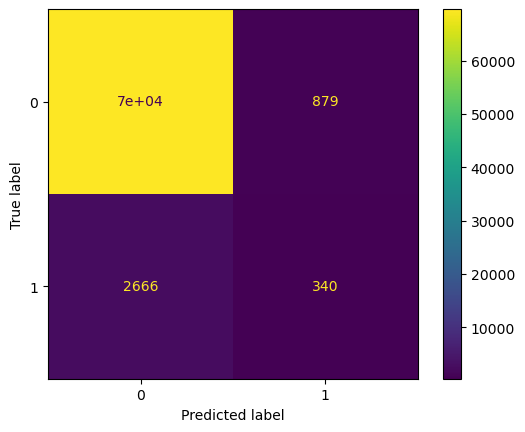

In [10]:
# Visualize the results = via confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

In [11]:
# Feature Importances
# Identify the feature importances for each of the classes
# Class 0 - Hospitalized - N
indArr = np.argsort(model.feature_log_prob_[0])[len(model.feature_log_prob_[0])-10:]

for feature in indArr: 
    print(f'Class: {model.feature_names_in_[feature]}, Log Probability: {model.feature_log_prob_[0][feature]}')


print("Class 1 - Top 10")
# Class 1 - Hospitalized - Y
indArr = np.argsort(model.feature_log_prob_[1])[len(model.feature_log_prob_[1])-10:]
for feature in indArr: 
    print(f'Class: {model.feature_names_in_[feature]}, Log Probability: {model.feature_log_prob_[1][feature]}')


Class: location_alameda, Log Probability: -0.991731418317574
Class: race_Asian, Log Probability: -0.9575109280803034
Class: location_santa clara, Log Probability: -0.8421950828674465
Class: race_White, Log Probability: -0.8141933831737873
Class: sex_Male, Log Probability: -0.7676937372491377
Class: sex_Female, Log Probability: -0.6237743580083865
Class: age_group_18 to 49 years, Log Probability: -0.4652184844026106
Class: ethnicity_Non-Hispanic/Latino, Log Probability: -0.13755985573615526
Class: symptom_status_Symptomatic, Log Probability: -0.10122746623279788
Class: current_status_Laboratory-confirmed case, Log Probability: -0.041148778101135264
Class 1 - Top 10
Class: race_Asian, Log Probability: -1.223265527273555
Class: location_alameda, Log Probability: -0.9543146894216328
Class: sex_Female, Log Probability: -0.75760439517558
Class: race_White, Log Probability: -0.682888417598635
Class: age_group_65+ years, Log Probability: -0.6648346374139642
Class: sex_Male, Log Probability: -0

In [20]:
print(model.class_log_prior_)
#convert to actual

for num in model.class_log_prior_:
    print(np.exp(num))

[-0.04173742 -3.19715329]
0.9591215925215677
0.04087840747843198
